## Exploratory Data Analysis and Statistical Analysis on the Data

We will perform exploratory and statistical analysis on our data, to have preliminary answers to our research questions. We will observe and investigate the influence of the following factors on the ending score: 
1) The genre(s) of the movie
2) The release date and influence of historical events
3) The key personnel (actors, directors...)
4) The region and of production and language of the movie

In [23]:
# %%
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

# path
DATA_FOLDER = 'src/data/'
MOVIE_DATASET = DATA_FOLDER + 'movies_dataset_cleaned_with_director_vote_revenue.tsv'

# Dataset loading
movies = pd.read_csv(MOVIE_DATASET, sep='\t')

### 1. Influence of movie genres on the ending scores

How does the genre of a movie influence the type of ending it has (happy, tragic)? Certain genres may have a higher likelihood of happy or tragic endings.

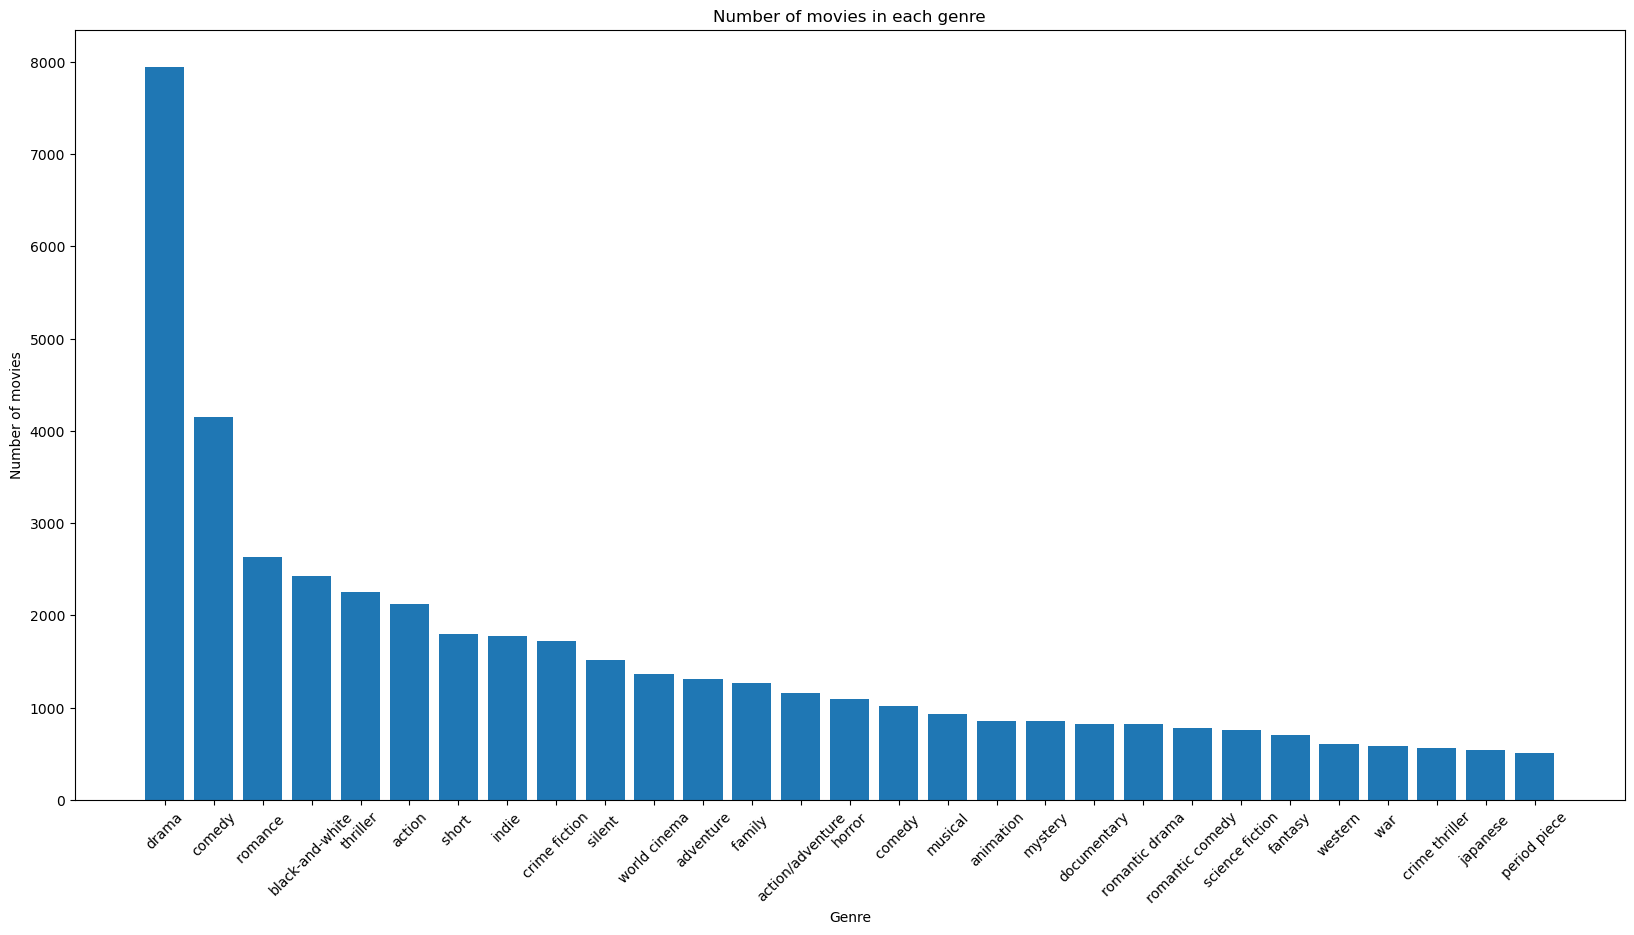

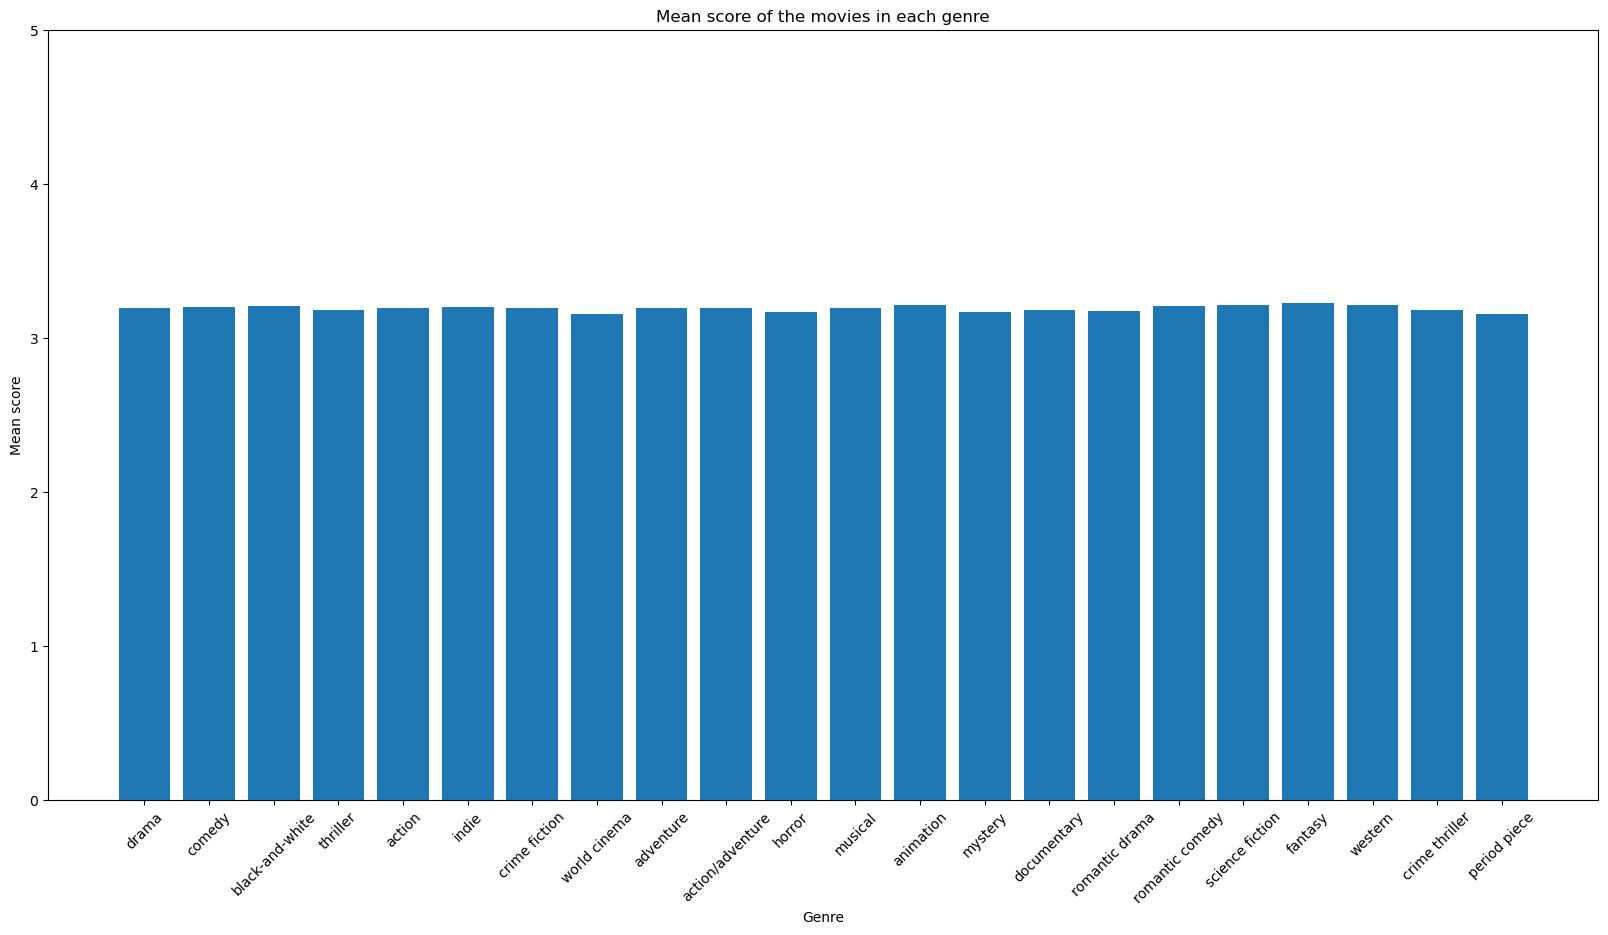

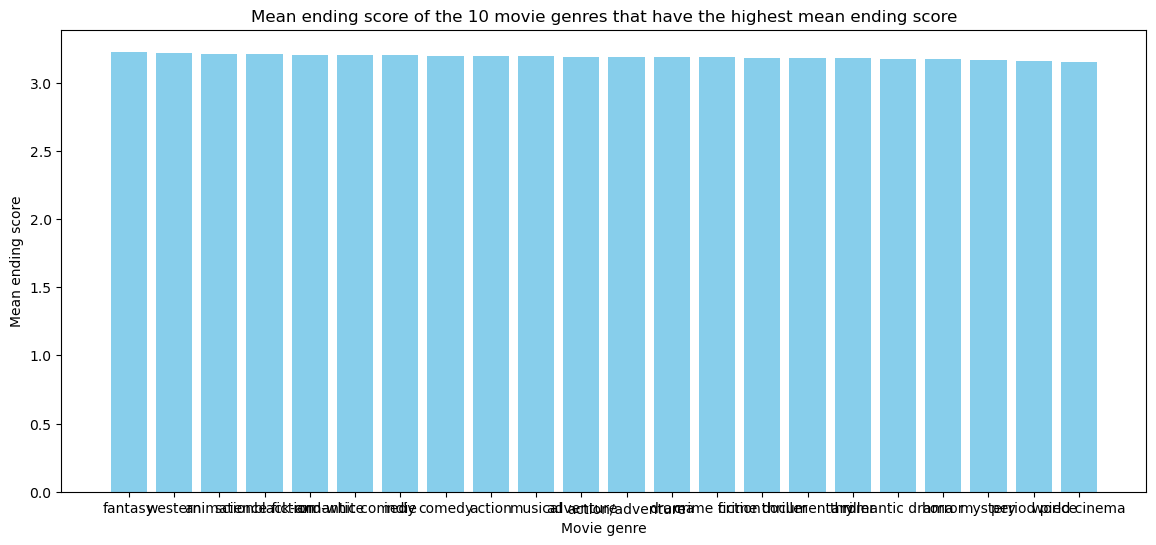

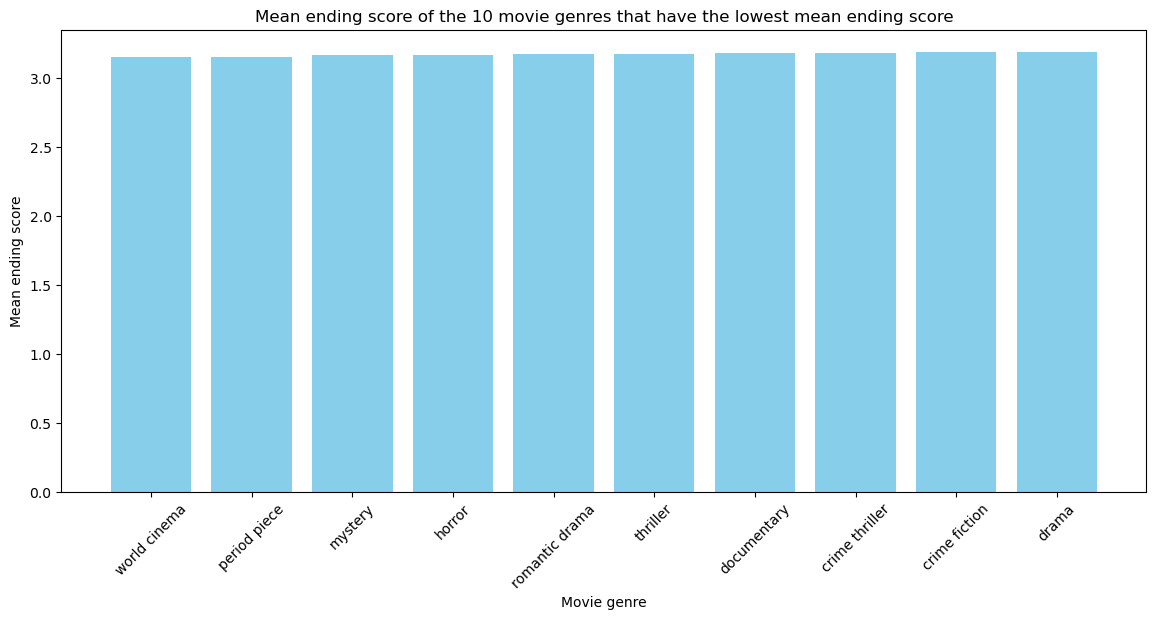

ANOVA F-statistic: 0.5615409600441515
ANOVA p-value: 0.9450240445103344
T-statistic: 1.028198911156292
P-value: 0.30390371989259674


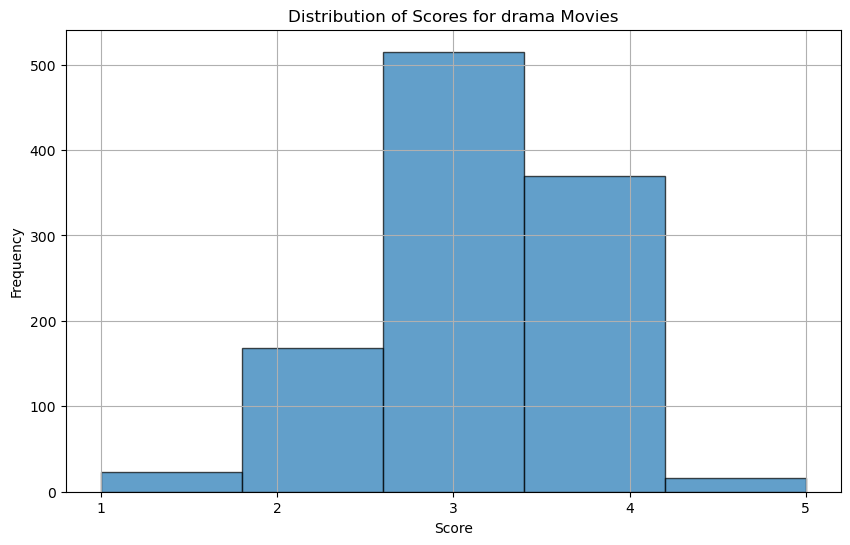

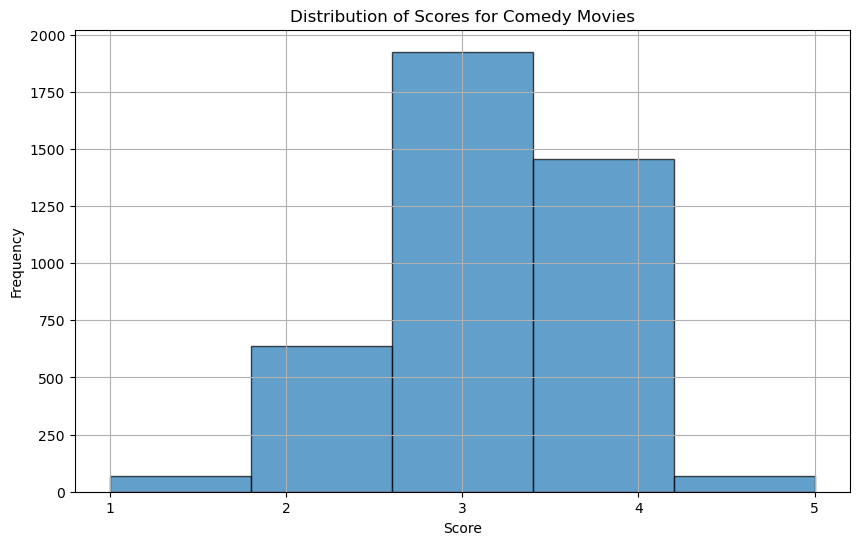

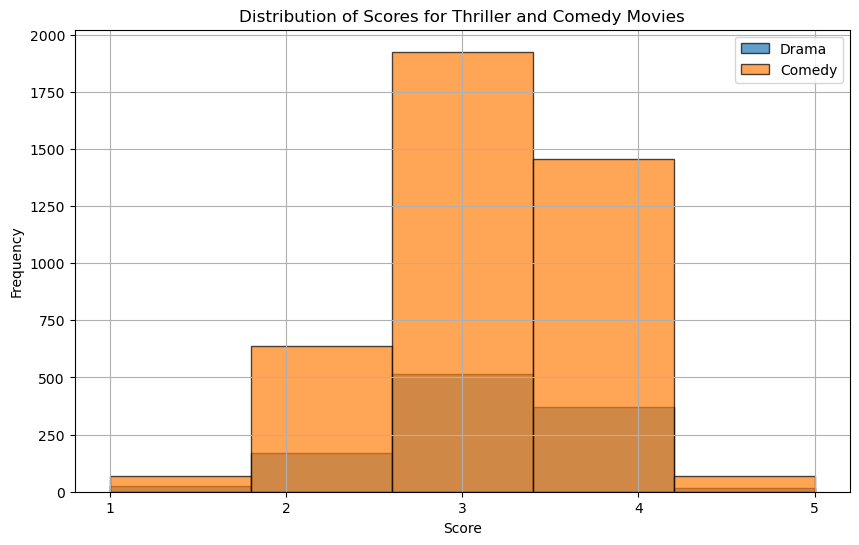

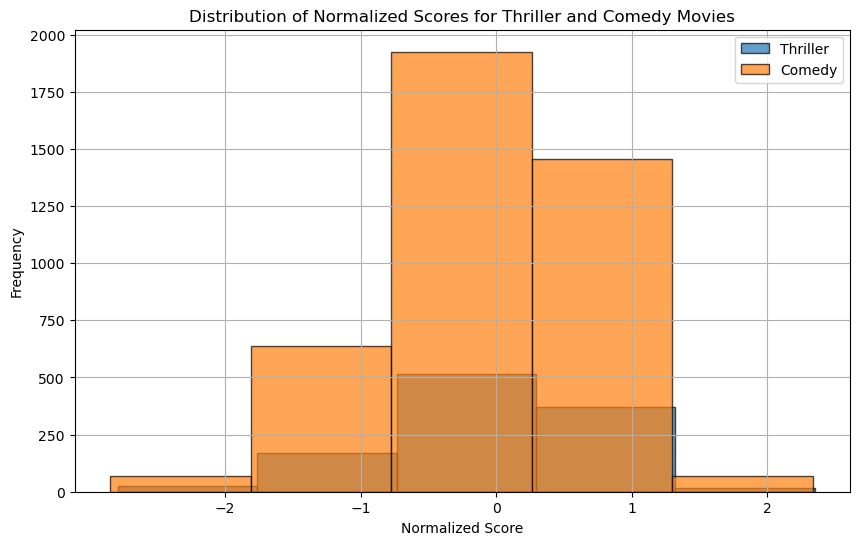

In [24]:
# %% [markdown]
# ## How does the genre of a movie influence the type of ending it has (happy, tragic, open-ended)? Certain genres may have a higher likelihood of happy or tragic endings.


# %% [markdown]
# What kind of genres do we have in this dataset ? And how many movies for each genre ?

# %%
# Get rid of the rows with no score
movies = movies.dropna(subset=['Score'])


genre_counts = movies['Movie genres'].str.split(', ').explode().value_counts().reset_index()
genre_counts.columns = ['Genre', 'Number of movies']
genre_counts = genre_counts.sort_values(by='Number of movies', ascending=False)
#print(genre_counts)


# %% [markdown]
# ## Cleaning and Filtering Movie Genres

# %% [markdown]
# We observe that we have 348 different movie genres. We will keep only the most common ones, and regroup the same genres that have not the exact same string.

# %%

#Remove the string 'film' or 'Film' or 'films' or 'Films' or 'movies' or 'Movies' from the 'Genre' colum of the genre_counts df

genre_counts['Genre'] = genre_counts['Genre'].str.replace('film', '')
genre_counts['Genre'] = genre_counts['Genre'].str.replace('Film', '')
genre_counts['Genre'] = genre_counts['Genre'].str.replace('films', '')
genre_counts['Genre'] = genre_counts['Genre'].str.replace('Films', '')
genre_counts['Genre'] = genre_counts['Genre'].str.replace('movies', '')
genre_counts['Genre'] = genre_counts['Genre'].str.replace('Movies', '')


genre_counts = genre_counts[genre_counts['Number of movies'] > 500]

genre_counts['Genre'] = genre_counts['Genre'].str.lower()

genre_counts


# %%
# Plot the number of movies in each genre for the 10 most popular genres
plt.figure(figsize=(20, 10))
plt.bar(genre_counts['Genre'], genre_counts['Number of movies'])
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.title('Number of movies in each genre')
plt.show()

# %% [markdown]
# Now that we have cleaned, regrouped and selected the movie genres, we will create a new dataset with only the movies that have any of these 45 genres of our interest. 

# %%
# Copy the movies dataframe into a new dataframe called movies_genres that contains exploses the list of strings in the 'Movie genres' column and so has a row for each genre of each movie
movies_genres = movies.copy()
movies_genres['Movie genres'] = movies_genres['Movie genres'].str.split(', ')
movies_genres = movies_genres.explode('Movie genres')
movies_genres = movies_genres.reset_index(drop=True)
movies_genres['Movie genres'] = movies_genres['Movie genres'].str.lower()
movies_genres.head(20)

# %% [markdown]
# In this new dataframe movies_genre, there is a row for each genre of one movie. Now we will keep only the rows for which the genre is part of our list of genres of interest.

# %%
# Remove the rows of the movies_genres dataframe that have a genre that is not in the genre_counts dataframe
movies_genres = movies_genres[movies_genres['Movie genres'].isin(genre_counts['Genre'])]
movies_genres = movies_genres.reset_index(drop=True)
movies_genres.head(10)

# %% [markdown]
# Now that we have clean data with only the most relevant genres for each film, we can anlayze it.

# %% [markdown]
# ## Analysis of the ending depending on the movie genres

# %% [markdown]
# First we can observe the normalized mean score of ending for each movie genre.

# %%
# For each genre, calculate the mean Score of the movies that have this genre and the number of movies that have this genre in the movies_genres dataframe
genre_scores = movies_genres.groupby('Movie genres').agg({'Score': 'mean', 'Movie genres': 'count'})
genre_scores.columns = ['Mean score', 'Number of movies']
genre_scores = genre_scores.reset_index()
genre_scores = genre_scores.sort_values(by='Number of movies', ascending=False)
genre_scores = genre_scores.reset_index(drop=True)

# Plot the mean score of the movies for the 10 genres that have the most movies in the movies_genres dataframe with a mean score axis going from zero to 5

plt.figure(figsize=(20, 10))
plt.bar(genre_scores['Movie genres'], genre_scores['Mean score'])
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.ylabel('Mean score')
plt.title('Mean score of the movies in each genre')
plt.ylim(0, 5)
plt.show()




# %%
genre_scores.head(15)

# %%
# Plot the score of the 10 movie genres that have the highest mean score
genre_scores = genre_scores.sort_values(by='Mean score', ascending=False)
genre_scores = genre_scores.reset_index(drop=True)

plt.figure(figsize=(14, 6))
plt.bar(genre_scores['Movie genres'], genre_scores['Mean score'], color='skyblue')
plt.xlabel('Movie genre')
plt.ylabel('Mean ending score')
plt.title('Mean ending score of the 10 movie genres that have the highest mean ending score')


# %%
# Sort the genre_scores dataframe by the lowest mean score
genre_scores = genre_scores.sort_values(by='Mean score', ascending=True)
genre_scores = genre_scores.reset_index(drop=True)

plt.figure(figsize=(14, 6))
plt.bar(genre_scores['Movie genres'][:10], genre_scores['Mean score'][:10], color='skyblue')
plt.xlabel('Movie genre')
plt.ylabel('Mean ending score')
plt.title('Mean ending score of the 10 movie genres that have the lowest mean ending score')
plt.xticks(rotation=45)
plt.show()

# %% [markdown]
# To observe correlation, we cannnot really use spearman or pearson cause not really suited for categorical data (movie genres in our case). We could maybe use a point - biserial correlation (special type of Pearson correlation) because it measures the relationship between a binary categorical variable (yes or no) and a continuous variable. We could use it for example in a case where we classifiy the genres such as action and no-action movies and see if there is a correlation in the ending scores.

# %% [markdown]
# For statistical dependency a t-test would be done between 2 genres for example romance movies and thriller, to see if there is a significant difference in the ending score.
# To see if there is a significant difference in the ending score for all genres, we can perform an ANOVA test.

# %% [markdown]
# Let's start by performing an ANOVA (Analysis of Variance) test to see if there are statistically significant differences in ending scores among different genres.
# Null hypothesis: There is no significant difference in the movie scores across different genres
# Alternative Hypothesis: There is a significant difference in the mean movie scores across different genres.
# 
# CAREFUL: 
# 1) ANOVA assumes normally distributed data and similar variances across groups. With a large dataset, ANOVA is fairly robust to these assumptions, but it’s worth verifying if the assumptions hold.
# 
# 2) NOVA only tells us if there is a difference somewhere among the genres, not which specific genres differ.

# %%
# ANOVA test
from scipy.stats import f_oneway

# Create a dictionary to store ending scores for each genre
genre_groups = movies_genres.groupby('Movie genres')['Score'].apply(list)

# Use f_oneway to perform ANOVA across all genre groups
anova_result = f_oneway(*genre_groups)

print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# %% [markdown]
# Interpretation: Since the p-value is very high, we cannot reject the null hypothesis. In other words, there isn't enough evidence to say that movie genres have a significant effect on the ending score.

# %% [markdown]
# T-TEST betwteen 2 genres

# %%
from scipy import stats

# Genres to compare
genre_1 = 'comedy'
genre_2 = 'horror'

# Extract scores for the movies that belong to each genre
genre_1_scores = movies_genres[movies_genres['Movie genres'] == genre_1]['Score']
genre_2_scores = movies_genres[movies_genres['Movie genres'] == genre_2]['Score']

# Perform a t-test between the two genres' scores
t_stat, p_value = stats.ttest_ind(genre_1_scores.dropna(), genre_2_scores.dropna())

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


# %%
import matplotlib.pyplot as plt

# Extract the scores for Thriller movies
horror_scores = movies_genres[movies_genres['Movie genres'] == 'horror']['Score']

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(horror_scores.dropna(), bins=5, edgecolor='black', alpha=0.7)
plt.title('Distribution of Scores for drama Movies')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xticks([1, 2, 3, 4, 5])  # Set x-axis ticks for score values
plt.grid(True)
plt.show()


# %%
import matplotlib.pyplot as plt

# Extract the scores for Thriller movies
comedy_scores = movies_genres[movies_genres['Movie genres'] == 'comedy']['Score']

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(comedy_scores.dropna(), bins=5, edgecolor='black', alpha=0.7)
plt.title('Distribution of Scores for Comedy Movies')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xticks([1, 2, 3, 4, 5])  # Set x-axis ticks for score values
plt.grid(True)
plt.show()



# %%
#plot score for thriller and comedy movies together
plt.figure(figsize=(10, 6))
plt.hist(horror_scores.dropna(), bins=5, edgecolor='black', alpha=0.7, label='Drama')
plt.hist(comedy_scores.dropna(), bins=5, edgecolor='black', alpha=0.7, label='Comedy')
plt.title('Distribution of Scores for Thriller and Comedy Movies')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xticks([1, 2, 3, 4, 5])  # Set x-axis ticks for score values
plt.legend()
plt.grid(True)
plt.show()


# %%
#normalize the scores for thriller and comedy movies
thriller_scores_normalized = (horror_scores - horror_scores.mean()) / horror_scores.std()
comedy_scores_normalized = (comedy_scores - comedy_scores.mean()) / comedy_scores.std()

#plot normalized scores for thriller and comedy movies together
plt.figure(figsize=(10, 6))
plt.hist(thriller_scores_normalized.dropna(), bins=5, edgecolor='black', alpha=0.7, label='Thriller')
plt.hist(comedy_scores_normalized.dropna(), bins=5, edgecolor='black', alpha=0.7, label='Comedy')
plt.title('Distribution of Normalized Scores for Thriller and Comedy Movies')
plt.xlabel('Normalized Score')
plt.ylabel('Frequency')
plt.xticks([-2, -1, 0, 1, 2])  # Set x-axis ticks for normalized score values
plt.legend()
plt.grid(True)
plt.show()


DISCUSSION AND INTERPRETATION

### 2. Release date and Influence of historical events

### 3. Key personnel (actors, directors)

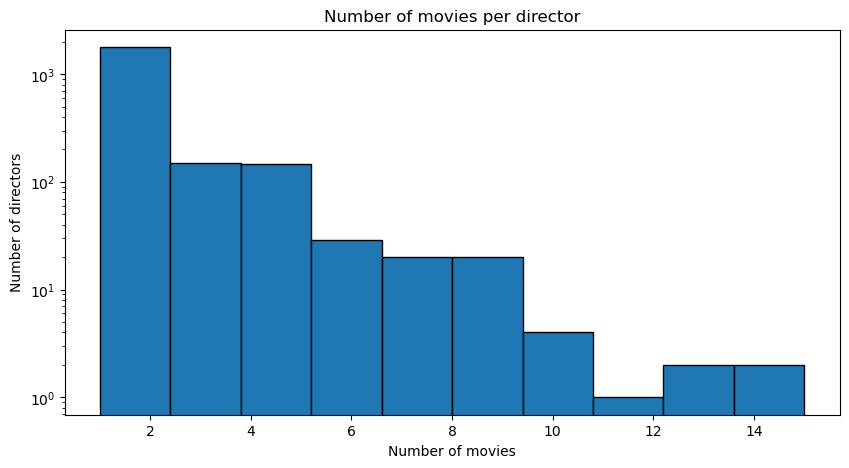

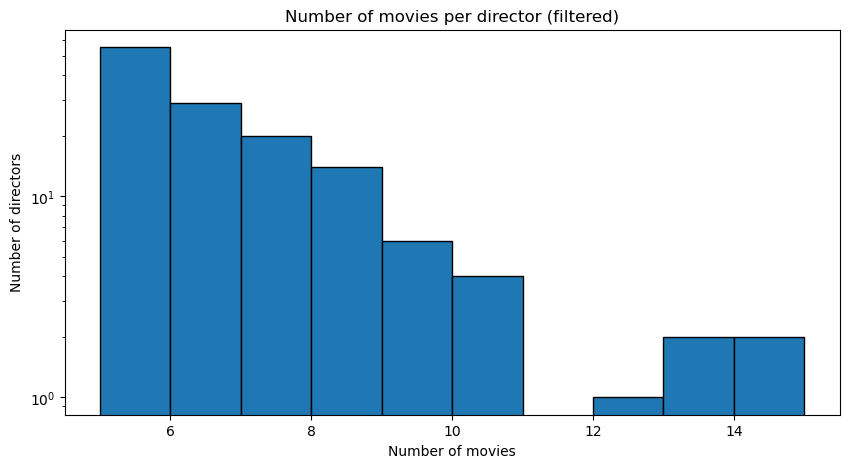

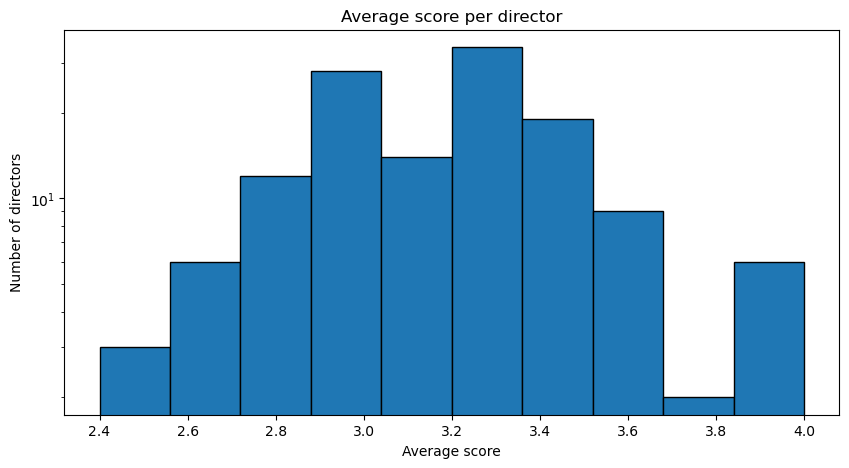

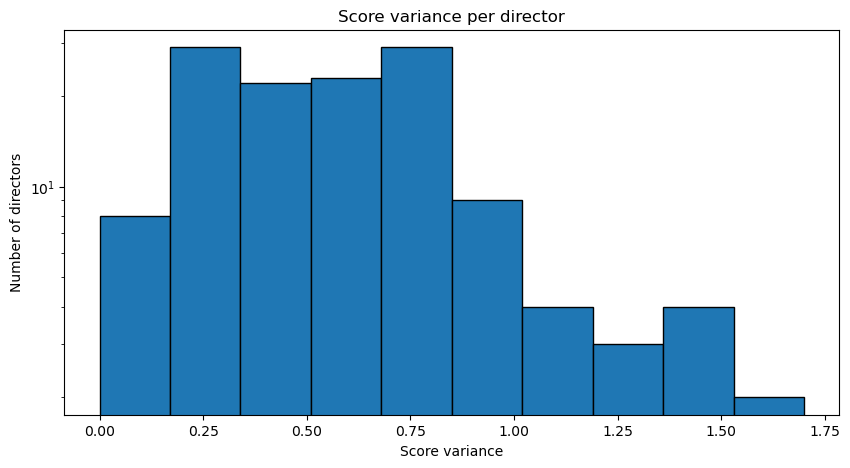

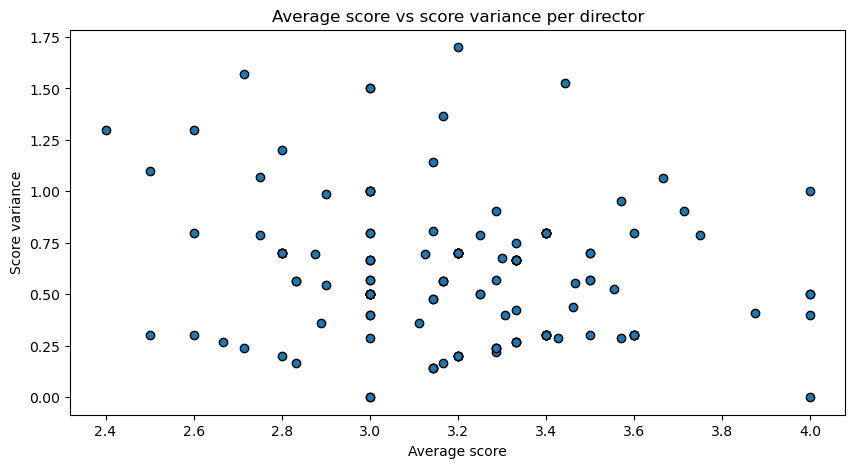

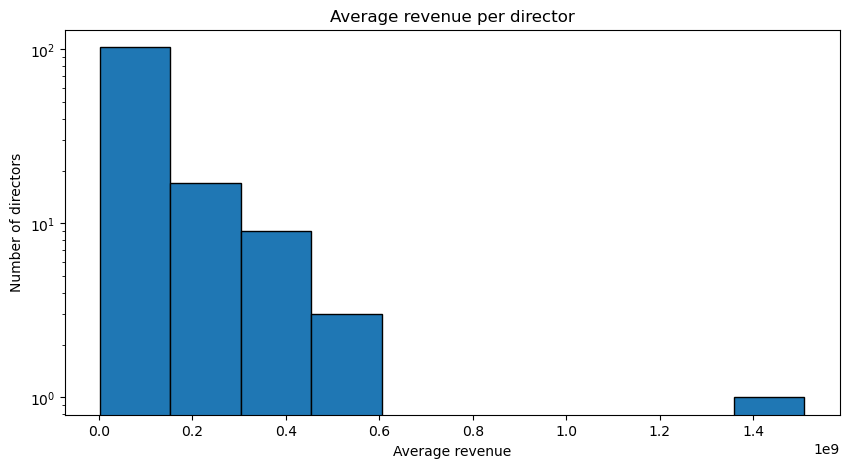

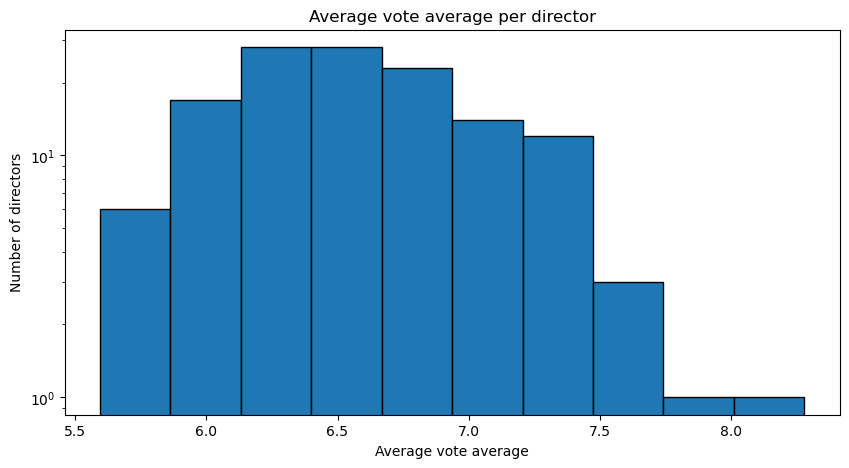

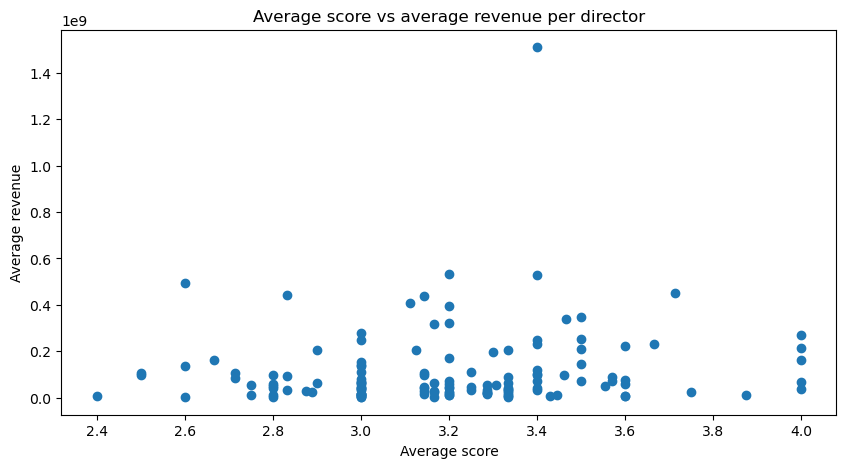

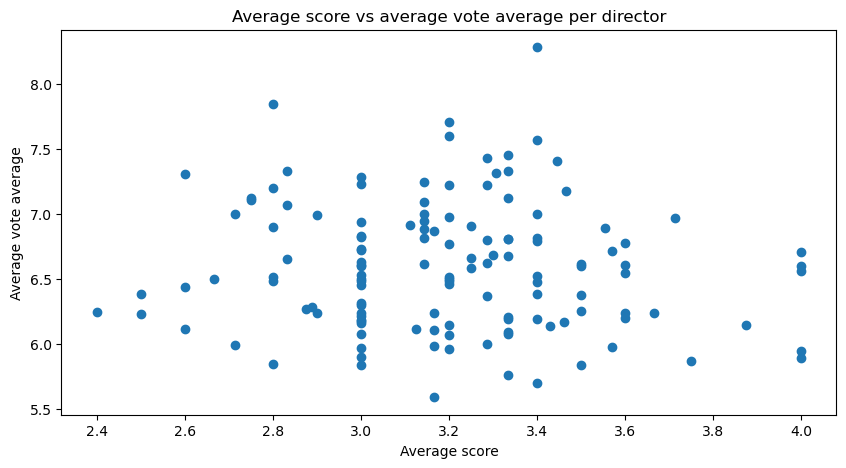

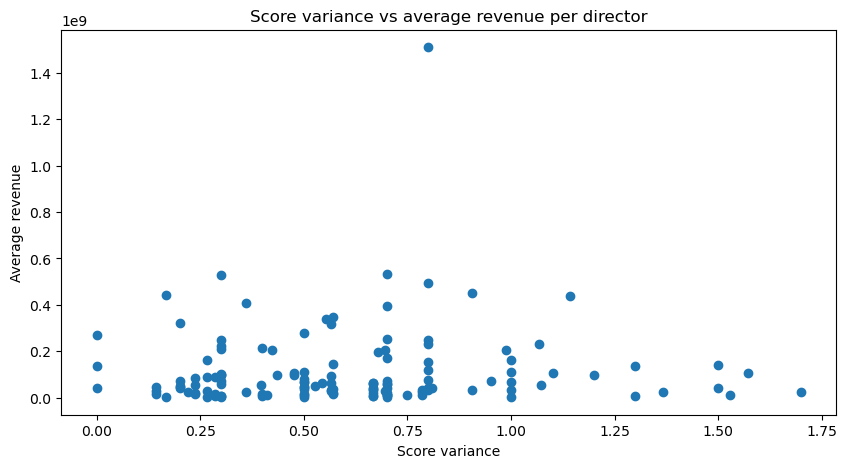

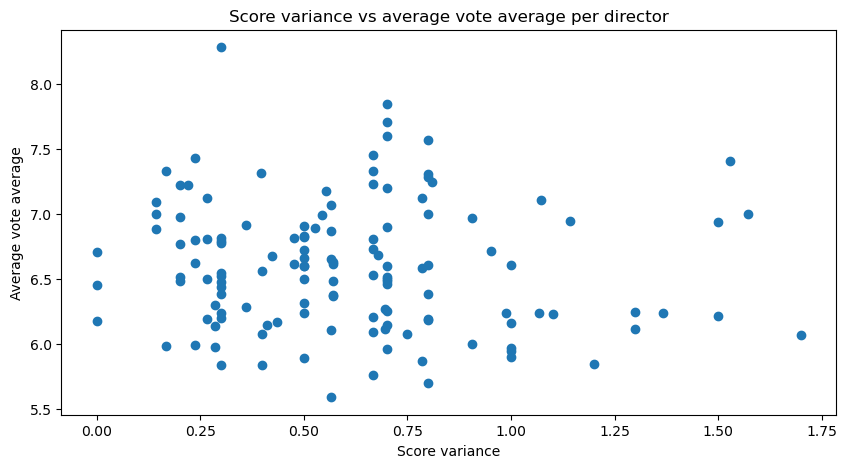

t stat: 2.279961155186647
p value: 0.02422599117351782
The average score is significantly different between directors with high and low revenue
t stat: -1.210075796758246
p value: 0.2284455167529968
The average score is not significantly different between directors with high and low vote average
t stat: -0.40556250776619396
p value: 0.6857256948927807
The score variance is not significantly different between directors with high and low revenue
t stat: -0.06539132155263837
p value: 0.9479628856482072
The score variance is not significantly different between directors with high and low vote average


KeyError: ['writer']

In [25]:
# %%
# drop movies without director
movies_filtered = movies.dropna(subset=['director'])

# drop movies without vote average or revenue
movies_filtered = movies_filtered.dropna(subset=['vote_average', 'revenue'])

# drop movies with revenue less than 1000
movies_filtered = movies_filtered[movies_filtered['revenue'] > 1000]

# %%
# count the number of movies per director
director_counts = movies_filtered['director'].value_counts()
director_counts

# %%
# plot the number of movies per director
plt.figure(figsize=(10, 5))
plt.hist(director_counts, edgecolor='black', log=True)
plt.xlabel('Number of movies')
plt.ylabel('Number of directors')
plt.title('Number of movies per director')
plt.show()

# %%
# filter out directors with more than 4 movies
directors = director_counts[director_counts > 4].index
movies_filtered = movies_filtered[movies_filtered['director'].isin(directors)]

# count the number of movies per director
director_counts_filtered = movies_filtered['director'].value_counts()
director_counts_filtered

# %%
# plot the number of movies per director
plt.figure(figsize=(10, 5))
plt.hist(director_counts_filtered, edgecolor='black', log=True)
plt.xlabel('Number of movies')
plt.ylabel('Number of directors')
plt.title('Number of movies per director (filtered)')
plt.show()

# %%
# count the number of movies per director, separated by the score of the movie
director_counts_filtered_score = movies_filtered.groupby(['director', 'Score']).size()
director_counts_filtered_score

# %%
# calculate the average score per director, and sort the directors by score
director_avg_score = movies_filtered.groupby('director')['Score'].mean()
director_avg_score = director_avg_score.sort_values(ascending=False)
director_avg_score

# %%
# plot the average score per director
plt.figure(figsize=(10, 5))
plt.hist(director_avg_score, edgecolor='black', log=True)
plt.xlabel('Average score')
plt.ylabel('Number of directors')
plt.title('Average score per director')
plt.show()


# %%
# calculate the score variance per director, and sort the directors by variance
director_score_variance = movies_filtered.groupby('director')['Score'].var()
director_score_variance = director_score_variance.sort_values(ascending=False)
director_score_variance

# %%
# plot the score variance per director
plt.figure(figsize=(10, 5))
plt.hist(director_score_variance, edgecolor='black', log=True)
plt.xlabel('Score variance')
plt.ylabel('Number of directors')
plt.title('Score variance per director')
plt.show()

# %%
# plot the average score vs the score variance per director
plt.figure(figsize=(10, 5))
x_values = director_avg_score.index
plt.scatter(director_avg_score, director_score_variance[x_values], edgecolor='black')
plt.xlabel('Average score')
plt.ylabel('Score variance')
plt.title('Average score vs score variance per director')
plt.show()

# %%
# calculate the average revenue per director, and sort the directors by revenue
director_avg_revenue = movies_filtered.groupby('director')['revenue'].mean()
director_avg_revenue = director_avg_revenue.sort_values(ascending=False)
director_avg_revenue

# %%
# plot the average revenue per director
plt.figure(figsize=(10, 5))
plt.hist(director_avg_revenue, edgecolor='black', log=True)
plt.xlabel('Average revenue')
plt.ylabel('Number of directors')
plt.title('Average revenue per director')
plt.show()

# %%
# calculate the average vote average per director, and sort the directors by vote average
director_avg_vote_average = movies_filtered.groupby('director')['vote_average'].mean()
director_avg_vote_average = director_avg_vote_average.sort_values(ascending=False)
director_avg_vote_average

# %%
# plot the average vote average per director
plt.figure(figsize=(10, 5))
plt.hist(director_avg_vote_average, edgecolor='black', log=True)
plt.xlabel('Average vote average')
plt.ylabel('Number of directors')
plt.title('Average vote average per director')
plt.show()

# %%
# analyze the correlation between the average score and the average revenue per director
plt.figure(figsize=(10, 5))
x_values = director_avg_score.index
plt.scatter(director_avg_score, director_avg_revenue[x_values])
plt.xlabel('Average score')
plt.ylabel('Average revenue')
plt.title('Average score vs average revenue per director')
plt.show()

# %%
# analyze the correlation between the average score and the average vote average per director
plt.figure(figsize=(10, 5))
x_values = director_avg_score.index
plt.scatter(director_avg_score, director_avg_vote_average[x_values])
plt.xlabel('Average score')
plt.ylabel('Average vote average')
plt.title('Average score vs average vote average per director')
plt.show()

# %%
# analyze the correlation between the score variance and the average revenue per director
plt.figure(figsize=(10, 5))
x_values = director_score_variance.index
plt.scatter(director_score_variance, director_avg_revenue[x_values])
plt.xlabel('Score variance')
plt.ylabel('Average revenue')
plt.title('Score variance vs average revenue per director')
plt.show()

# %%
# analyze the correlation between the score variance and the average vote average per director
plt.figure(figsize=(10, 5))
x_values = director_score_variance.index
plt.scatter(director_score_variance, director_avg_vote_average[x_values])
plt.xlabel('Score variance')
plt.ylabel('Average vote average')
plt.title('Score variance vs average vote average per director')
plt.show()

# %%
# use t test to check if the average score is significantly different between directors with high and low revenue
from scipy.stats import ttest_ind

high_revenue_directors = director_avg_revenue[director_avg_revenue > 0.2e9].index
low_revenue_directors = director_avg_revenue[director_avg_revenue < 0.2e9].index

high_revenue_director_avg_score = director_avg_score[high_revenue_directors].dropna()
low_revenue_director_avg_score = director_avg_score[low_revenue_directors].dropna()

t_stat, p_value = ttest_ind(high_revenue_director_avg_score, low_revenue_director_avg_score)
print('t stat:', t_stat)
print('p value:', p_value)

if p_value < 0.05:
    print('The average score is significantly different between directors with high and low revenue')
else:
    print('The average score is not significantly different between directors with high and low revenue')


# %%
# use t test to check if the average score is significantly different between directors with high and low vote average

high_vote_average_directors = director_avg_vote_average[director_avg_vote_average > 7].index
low_vote_average_directors = director_avg_vote_average[director_avg_vote_average < 7].index

high_vote_average_director_avg_score = director_avg_score[high_vote_average_directors].dropna()
low_vote_average_director_avg_score = director_avg_score[low_vote_average_directors].dropna()

t_stat, p_value = ttest_ind(high_vote_average_director_avg_score, low_vote_average_director_avg_score)
print('t stat:', t_stat)
print('p value:', p_value)

if p_value < 0.05:
    print('The average score is significantly different between directors with high and low vote average')
else:
    print('The average score is not significantly different between directors with high and low vote average')

# %%
# use t test to check if the score variance is significantly different between directors with high and low revenue

high_revenue_director_score_variance = director_score_variance[high_revenue_directors].dropna()
low_revenue_director_score_variance = director_score_variance[low_revenue_directors].dropna()

t_stat, p_value = ttest_ind(high_revenue_director_score_variance, low_revenue_director_score_variance)
print('t stat:', t_stat)
print('p value:', p_value)

if p_value < 0.05:
    print('The score variance is significantly different between directors with high and low revenue')
else:
    print('The score variance is not significantly different between directors with high and low revenue')

# %%
# use t test to check if the score variance is significantly different between directors with high and low vote average

high_vote_average_director_score_variance = director_score_variance[high_vote_average_directors].dropna()
low_vote_average_director_score_variance = director_score_variance[low_vote_average_directors].dropna()

t_stat, p_value = ttest_ind(high_vote_average_director_score_variance, low_vote_average_director_score_variance)
print('t stat:', t_stat)
print('p value:', p_value)

if p_value < 0.05:
    print('The score variance is significantly different between directors with high and low vote average')
else:
    print('The score variance is not significantly different between directors with high and low vote average')

# %%
# drop movies without writer
movies_filtered = movies.dropna(subset=['writer'])

# drop movies without vote average or revenue
movies_filtered = movies_filtered.dropna(subset=['vote_average', 'revenue'])

# drop movies with revenue less than 1000
movies_filtered = movies_filtered[movies_filtered['revenue'] > 1000]

# %%
# count the number of movies per writer
writer_counts = movies_filtered['writer'].value_counts()
writer_counts

# %%
# plot the number of movies per writer
plt.figure(figsize=(10, 5))
plt.hist(writer_counts, edgecolor='black', log=True)
plt.xlabel('Number of movies')
plt.ylabel('Number of writers')
plt.title('Number of movies per writer')
plt.show()

# %%
# filter out writers with more than 4 movies
writers = writer_counts[writer_counts > 4].index
movies_filtered = movies_filtered[movies_filtered['writer'].isin(writers)]

# %%
# count the number of movies per writer
writer_counts_filtered = movies_filtered['writer'].value_counts()
writer_counts_filtered

# %%
# plot the number of movies per writer
plt.figure(figsize=(10, 5))
plt.hist(writer_counts_filtered, edgecolor='black', log=True)
plt.xlabel('Number of movies')
plt.ylabel('Number of writers')
plt.title('Number of movies per writer (filtered)')
plt.show()

# %%
# count the number of movies per writer, separated by the score of the movie
writer_counts_filtered_score = movies_filtered.groupby(['writer', 'Score']).size()
writer_counts_filtered_score

# %%
# calculate the average score per writer, and sort the writers by score
writer_avg_score = movies_filtered.groupby('writer')['Score'].mean()
writer_avg_score = writer_avg_score.sort_values(ascending=False)
writer_avg_score

# %%
# plot the average score per writer
plt.figure(figsize=(10, 5))
plt.hist(writer_avg_score, edgecolor='black')
plt.xlabel('Average score')
plt.ylabel('Number of writers')
plt.title('Average score per writer')
plt.show()

# %%
# calculate the score variance per writer, and sort the writers by variance
writer_score_variance = movies_filtered.groupby('writer')['Score'].var()
writer_score_variance = writer_score_variance.sort_values(ascending=False)
writer_score_variance

# %%
# plot the score variance per writer
plt.figure(figsize=(10, 5))
plt.hist(writer_score_variance, edgecolor='black')
plt.xlabel('Score variance')
plt.ylabel('Number of writers')
plt.title('Score variance per writer')
plt.show()

# %%
# plot the score variance vs the average score per writer
plt.figure(figsize=(10, 5))
x_values = writer_avg_score.index
plt.scatter(writer_avg_score, writer_score_variance[x_values], edgecolor='black')
plt.xlabel('Average score')
plt.ylabel('Score variance')
plt.title('Average score vs score variance per writer')
plt.show()

# %%
# calculate the average revenue per writer, and sort the writers by revenue
writer_avg_revenue = movies_filtered.groupby('writer')['revenue'].mean()
writer_avg_revenue = writer_avg_revenue.sort_values(ascending=False)
writer_avg_revenue

# %%
# plot the average revenue per writer
plt.figure(figsize=(10, 5))
plt.hist(writer_avg_revenue, edgecolor='black')
plt.xlabel('Average revenue')
plt.ylabel('Number of writers')
plt.title('Average revenue per writer')
plt.show()

# %%
# calculate the average vote average per writer, and sort the writers by vote average
writer_avg_vote_average = movies_filtered.groupby('writer')['vote_average'].mean()
writer_avg_vote_average = writer_avg_vote_average.sort_values(ascending=False)
writer_avg_vote_average

# %%
# plot the average vote average per writer
plt.figure(figsize=(10, 5))
plt.hist(writer_avg_vote_average, edgecolor='black')
plt.xlabel('Average vote average')
plt.ylabel('Number of writers')
plt.title('Average vote average per writer')
plt.show()

# %%
# analyze the correlation between the average score and the average revenue per writer
plt.figure(figsize=(10, 5))
x_values = writer_avg_score.index
plt.scatter(writer_avg_score, writer_avg_revenue[x_values])
plt.xlabel('Average score')
plt.ylabel('Average revenue')
plt.title('Average score vs average revenue per writer')
plt.show()

# %%
# analyze the correlation between the average score and the average vote average per writer
plt.figure(figsize=(10, 5))
x_values = writer_avg_score.index
plt.scatter(writer_avg_score, writer_avg_vote_average[x_values])
plt.xlabel('Average score')
plt.ylabel('Average vote average')
plt.title('Average score vs average vote average per writer')
plt.show()

# %%
# analyze the correlation between the score variance and the average revenue per writer
plt.figure(figsize=(10, 5))
x_values = writer_score_variance.index
plt.scatter(writer_score_variance, writer_avg_revenue[x_values])
plt.xlabel('Score variance')
plt.ylabel('Average revenue')
plt.title('Score variance vs average revenue per writer')
plt.show()

# %%
# analyze the correlation between the score variance and the average vote average per writer
plt.figure(figsize=(10, 5))
x_values = writer_score_variance.index
plt.scatter(writer_score_variance, writer_avg_vote_average[x_values])
plt.xlabel('Score variance')
plt.ylabel('Average vote average')
plt.title('Score variance vs average vote average per writer')
plt.show()

### 4. Influence of or on the movie's 'success'

Is there a correlation between a movie’s ending and its success (ratings, box office revenue, etc.)?

We will explore whether happy or tragic endings have any impact on a movie's popularity or financial performance.

To do so, we used the the tmdb dataset to augment our dataset and to provide the information of the box office revenue (more complete because in our own dataset we only had this information for ~10% of the movies) and the vote average, which is an average of the audience's rating on the movie. 

In [ ]:
# %%
# drop movies without vote average or revenue
movies_filtered = movies(subset=['vote_average', 'revenue'])

# drop movies with revenue less than 1000
movies_filtered = movies_filtered[movies_filtered['revenue'] > 1000]

# %%
# plot score vs revenue
plt.scatter(movies_filtered['Score'], movies_filtered['revenue'])
plt.xlabel('Score')
plt.ylabel('Revenue')
plt.title('Score vs Revenue')
plt.show()

# %%
# plot score vs vote average
plt.scatter(movies_filtered['Score'], movies_filtered['vote_average'])
plt.xlabel('Score')
plt.ylabel('Vote Average')
plt.title('Score vs Vote Average')
plt.show()


# %%
# calculate the average revenue for each score
average_revenue = movies_filtered.groupby('Score')['revenue'].mean()
average_revenue = average_revenue.sort_index()

# plot average revenue vs score
plt.plot(average_revenue)
plt.xlabel('Score')
plt.ylabel('Average Revenue')
plt.title('Average Revenue vs Score')
plt.show()

# %%
# calculate the average vote average for each score
average_vote_average = movies_filtered.groupby('Score')['vote_average'].mean()
average_vote_average = average_vote_average.sort_index()

# plot average vote average vs score
plt.plot(average_vote_average)
plt.xlabel('Score')
plt.ylabel('Average Vote Average')
plt.title('Average Vote Average vs Score')
plt.show()

# %%
# use t test to test if the average revenue is different for movies with score 1 and movies with score 5
from scipy.stats import ttest_ind

movies_score_1_revenue = movies_filtered[movies_filtered['Score'] == 1.0]['revenue'].astype(float)
movies_score_5_revenue = movies_filtered[movies_filtered['Score'] == 5.0]['revenue'].astype(float)

t_stat, p_value = ttest_ind(movies_score_1_revenue, movies_score_5_revenue)

print('t-statistic:', t_stat)
print('p-value:', p_value)

if p_value < 0.05:
    print('The difference is statistically significant')
else:
    print('The difference is not statistically significant')

# %%
# use t test to test if the average vote average is different for movies with score 1 and movies with score 5
movies_score_1_vote_average = movies_filtered[movies_filtered['Score'] == 1.0]['vote_average'].astype(float)
movies_score_5_vote_average = movies_filtered[movies_filtered['Score'] == 5.0]['vote_average'].astype(float)

t_stat, p_value = ttest_ind(movies_score_1_vote_average, movies_score_5_vote_average)

print('t-statistic:', t_stat)
print('p-value:', p_value)

if p_value < 0.05:
    print('The difference is statistically significant')
else:
    print('The difference is not statistically significant')

# %%

TypeError: 'DataFrame' object is not callable